# Introduction

In this notebook we will demonstrate the use of a custom parser for `.mod` files written in PyParsing. In DendroTweaks, this parser automatically creates Python classes for ion channels that provide an interface to the channel models for visualization and refinement.

# Imports

In [1]:
import sys
sys.path.append('app')

In [2]:
from model.mechanisms.pparser import parser
from pprint import pprint

# Parsing a `.mod` file

We'll parse a `.mod` file describing a potassium channel from Park et al. 2019. The parse method reads data from the file and applies the grammar defined in `app/model/mechanisms/pparsing.py` to obtain an abstract syntax tree (AST).

In [3]:
file_name = 'Park_Kv'
path_to_file = f'app/model/mechanisms/mod/{file_name}/{file_name}.mod'
print(path_to_file)
parser.parse(mod_file=path_to_file)

app/model/mechanisms/mod/Park_Kv/Park_Kv.mod


In [4]:
parser.ast

{'mod_file': {'title': ' Kv_Park_ref',
  'comment_block': '\n26 Ago 2002 Modification of original channel to allow variable time step and to correct an initialization error.\n    Done by Michael Hines(michael.hines@yale.e) and Ruggero Scorcioni(rscorcio@gmu.edu) at EU Advance Course in Computational Neuroscience. Obidos, Portugal\n\nkv.mod\n\nPotassium channel, Hodgkin-Huxley style kinetics\nKinetic rates based roughly on Sah et al. and Hamill et al. (1991)\n\nAuthor\n',
  'neuron_block': {'suffix': 'kv',
   'useion': [{'ion': 'k', 'read': ['ek'], 'write': ['ik']}],
   'range': ['gbar', 'i', 'v12', 'q']},
  'units_block': {'mA': 'milliamp',
   'mV': 'millivolt',
   'S': 'siemens',
   'um': 'micron'},
  'parameter_block': [{'name': 'gbar', 'value': 0.0, 'unit': 'S/cm2'},
   {'name': 'Ra', 'value': 0.02, 'unit': '/mV/ms'},
   {'name': 'Rb', 'value': 0.006, 'unit': '/mV/ms'},
   {'name': 'v12', 'value': 25, 'unit': 'mV'},
   {'name': 'q', 'value': 9, 'unit': 'mV'},
   {'name': 'temp', 'va

# NMODL blocks

Next, we'll print the NMODL blocks of the file one by one, comparing the original lines with their resulting AST representation.

In [5]:
print(parser._get_block_regex('UNITS')[0], '\n\n')
pprint(parser.ast['mod_file']['units_block'])

UNITS {
	(mA) = (milliamp)
	(mV) = (millivolt)
	(S)  = (siemens)
	(um) = (micron)
} 


{'S': 'siemens', 'mA': 'milliamp', 'mV': 'millivolt', 'um': 'micron'}


In [6]:
print(parser._get_block_regex('PARAMETER')[0], '\n\n')

pprint(parser.ast['mod_file']['parameter_block'])

PARAMETER {
	gbar = 0.0   (S/cm2)                                                                                      
	Ra   = 0.02  (/mV/ms) 
	Rb   = 0.006 (/mV/ms) 
	v12  = 25    (mV)	  
	q    = 9     (mV)     
	temp = 23    (degC)   
	q10  = 2.3   (1)	  
} 


[{'name': 'gbar', 'unit': 'S/cm2', 'value': 0.0},
 {'name': 'Ra', 'unit': '/mV/ms', 'value': 0.02},
 {'name': 'Rb', 'unit': '/mV/ms', 'value': 0.006},
 {'name': 'v12', 'unit': 'mV', 'value': 25},
 {'name': 'q', 'unit': 'mV', 'value': 9},
 {'name': 'temp', 'unit': 'degC', 'value': 23},
 {'name': 'q10', 'unit': '1', 'value': 2.3}]


In [7]:
print(parser._get_block_regex('ASSIGNED')[0], '\n\n')

pprint(parser.ast['mod_file']['assigned_block'])

ASSIGNED {
	v       (mV)
	i 	    (mA/cm2)
	ik      (mA/cm2)
	gk      (S/cm2)
	ek      (mV)
	ninf    (1)
	ntau    (ms)
	tadj    (1)
	celsius (degC)
} 


[{'name': 'v', 'unit': 'mV'},
 {'name': 'i', 'unit': 'mA/cm2'},
 {'name': 'ik', 'unit': 'mA/cm2'},
 {'name': 'gk', 'unit': 'S/cm2'},
 {'name': 'ek', 'unit': 'mV'},
 {'name': 'ninf', 'unit': '1'},
 {'name': 'ntau', 'unit': 'ms'},
 {'name': 'tadj', 'unit': '1'},
 {'name': 'celsius', 'unit': 'degC'}]


In [8]:
print(parser._get_block_regex('STATE')[0], '\n\n')

print(parser.ast['mod_file']['state_block'])

STATE { n } 


{'n': 1}


In [9]:
print(parser._get_block_regex('BREAKPOINT')[0], '\n\n')

pprint(parser.ast['mod_file']['breakpoint_block'])

BREAKPOINT {
    SOLVE states METHOD cnexp
	gk = tadj * gbar * n
	i = gk * (v - ek)
	ik = i
} 


{'solve_stmt': {'method': 'cnexp', 'solve': 'states'},
 'statements': [{'assigned_var': 'gk',
                 'expression': {'*': [{'*': ['tadj', 'gbar']}, 'n']}},
                {'assigned_var': 'i',
                 'expression': {'*': ['gk', {'-': ['v', 'ek']}]}},
                {'assigned_var': 'ik', 'expression': 'i'}]}


In [10]:
print(parser._get_block_regex('INITIAL')[0], '\n\n')

pprint(parser.ast['mod_file']['initial_block'])

INITIAL { 
	rates(v)
	n = ninf
} 


{'statements': [{'rates': ['v']}, {'assigned_var': 'n', 'expression': 'ninf'}]}


In [11]:
print(parser._get_block_regex('DERIVATIVE')[0], '\n\n')

pprint(parser.ast['mod_file']['derivative_block'])

DERIVATIVE  states {   
        rates(v)
        n' =  (ninf - n)/ntau
} 


{'func_calls': [{'rates': ['v']}],
 'name': 'states',
 'statements': [{'assigned_var': 'n',
                 'expression': {'/': [{'-': ['ninf', 'n']}, 'ntau']}}]}


In [12]:
print(f"Number of functions: {len(parser.ast['mod_file']['function_blocks'])}")

Number of functions: 1


In [13]:
print(parser._get_block_regex('FUNCTION')[0], '\n\n')

for f in parser.ast['mod_file']['function_blocks']:
    pprint(f)

FUNCTION rateconst(v (mV), r (/mV/ms), th (mV), q (mV)) (/ms) {
	rateconst = r * (v - th) / (1 - exp(-(v - th)/q))
} 


{'assignment_statements': [{'assigned_var': 'rateconst',
                            'expression': {'/': [{'*': ['r',
                                                        {'-': ['v', 'th']}]},
                                                 {'-': [1,
                                                        {'exp': [{'/': [{'-': [{'-': ['v',
                                                                                      'th']}]},
                                                                        'q']}]}]}]}}],
 'locals': [],
 'signature': {'f_name': 'rateconst',
               'params': [{'name': 'v', 'unit': 'mV'},
                          {'name': 'r', 'unit': '/mV/ms'},
                          {'name': 'th', 'unit': 'mV'},
                          {'name': 'q', 'unit': 'mV'}],
               'returned_unit': '/ms'},
 'statements': [{'assigned_var':

In [14]:
print(f"Number of procedures: {len(parser.ast['mod_file']['procedure_blocks'])}")

Number of procedures: 1


In [15]:
print(parser._get_block_regex('PROCEDURE')[0], '\n\n')

pprint(parser.ast['mod_file']['procedure_blocks'][0])

PROCEDURE rates(v (mV)) {

	LOCAL alpn, betn

	tadj = q10^((celsius - temp)/10(degC))

	alpn = rateconst(v, Ra, v12, q)
	betn = rateconst(v, -Rb, v12, -q)

    ntau = 1 / (tadj * (alpn + betn))
	ninf = alpn/(alpn + betn)
} 


{'assignment_statements': [{'assigned_var': 'tadj',
                            'expression': {'^': ['q10',
                                                 {'/': [{'-': ['celsius',
                                                               'temp']},
                                                        10]}]}},
                           {'assigned_var': 'alpn',
                            'expression': {'rateconst': ['v',
                                                         'Ra',
                                                         'v12',
                                                         'q']}},
                           {'assigned_var': 'betn',
                            'expression': {'rateconst': ['v',
                                  

# Building a Python Class

Using the AST representation, we can construct a Python class.

In [16]:
print(parser.ast_to_python())

import numpy as np
try:
    from ..channels import CustomVoltageDependentIonChannel
except:
    from channels import CustomVoltageDependentIonChannel

class Park_Kv(CustomVoltageDependentIonChannel):
    def __init__(self, cell=None):
        super().__init__(name='Park_Kv', suffix='kv', cell=cell)
        self.ion = 'k'
        self.range_params = [
            'gbar',
            'v12',
            'q',
        ]
        self.gbar = 0.0 # S/cm2
        self.Ra = 0.02 # /mV/ms
        self.Rb = 0.006 # /mV/ms
        self.v12 = 25 # mV
        self.q = 9 # mV
        self.temp = 23 # degC
        self.q10 = 2.3 # 1
        self.celsius = 37 # degC
        self.v = np.linspace(-100, 100, 1000)
        self.state_vars = {
            "n": {
                "inf": "ninf",
                "tau": "ntau",
                "power": 1
            },
        }

    def rateconst(self, v, r, th, q):
        rateconst = (r * (v - th)) / (1 - np.exp((-((v - th)) / q)))
        return rateconst

  

In [17]:
parser.write_python(py_file=f'app/model/mechanisms/collection/{file_name}.py')

Wrote app/model/mechanisms/collection/Park_Kv.py


# Using the Python class

Finally, we'll instantiate the Python class and visualize the channel's kinetics.

In [18]:
from model.mechanisms.collection.Park_Kv import Park_Kv

In [19]:
kv = Park_Kv()

In [20]:
import numpy as np
kv.update(np.linspace(-100, 100, 100)) # voltage in mV

In [21]:
kv.state_vars

{'n': {'inf': 'ninf', 'tau': 'ntau', 'power': 1}}

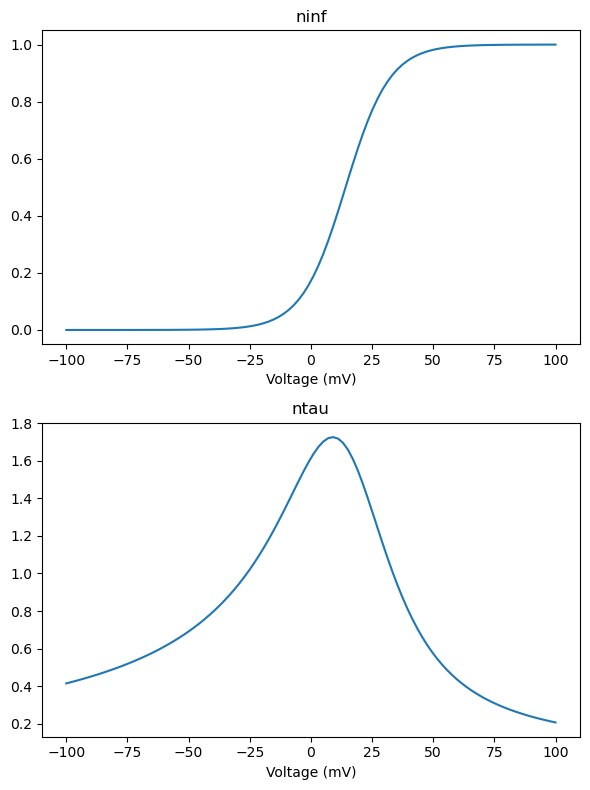

In [22]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 1, figsize=(6, 8))
plt.sca(axes[0])
plt.plot(np.linspace(-100, 100, 100), kv.ninf)
plt.xlabel('Voltage (mV)')
plt.title('ninf')
plt.sca(axes[1])
plt.plot(np.linspace(-100, 100, 100), kv.ntau)
plt.title('ntau')
plt.xlabel('Voltage (mV)')
plt.tight_layout()